In [2]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
train_dir = 'ravdess-emotional-video/train'
test_dir = 'ravdess-emotional-video/test'

emotion_labels = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'sad': 4, 'surprise': 5, 'neutral': 6}

In [4]:
def load_images_from_folder(directory, emotion_labels):
    all_images = []
    all_labels = []
    
    for emotion_name, label in emotion_labels.items():
        emotion_folder = os.path.join(directory, emotion_name)
        if os.path.exists(emotion_folder):
            for img_file in os.listdir(emotion_folder):
                img_path = os.path.join(emotion_folder, img_file)
                if img_path.endswith('.png') or img_path.endswith('.jpg'):
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (48, 48))  # Resize to 48x48
                    img = img / 255.0  # Normalize pixel values to [0, 1]
                    all_images.append(img)
                    all_labels.append(label)
    
    return np.array(all_images), np.array(all_labels)

In [5]:
def create_video_sequences(images, labels, window_size=10, step_size=5):
    videos = []
    seq_labels = []
    
    for i in range(0, len(images) - window_size, step_size):
        seq_images = images[i:i + window_size]  
        videos.append(seq_images)
        seq_labels.append(labels[i])  
    
    return np.array(videos), np.array(seq_labels)

In [6]:
train_images, train_labels = load_images_from_folder(train_dir, emotion_labels)
video_sequences, video_labels = create_video_sequences(train_images, train_labels)

video_sequences = video_sequences.reshape(video_sequences.shape[0], video_sequences.shape[1], 48, 48, 1)  # Grayscale image, so 1 channel

video_labels_one_hot = to_categorical(video_labels, num_classes=7)

X_train, X_val, y_train, y_val = train_test_split(video_sequences, video_labels_one_hot, test_size=0.2, random_state=42)

In [18]:
model = Sequential()

model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(10, 48, 48, 1)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten())) 

model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.7))

model.add(Dense(7, activation='softmax'))  

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step - accuracy: 0.2165 - loss: 1.8598 - val_accuracy: 0.3153 - val_loss: 1.7072
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.3868 - loss: 1.5118 - val_accuracy: 0.5906 - val_loss: 1.0876
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.5906 - loss: 1.0935 - val_accuracy: 0.7247 - val_loss: 0.7036
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.7158 - loss: 0.7647 - val_accuracy: 0.7152 - val_loss: 0.7499
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.7784 - loss: 0.6072 - val_accuracy: 0.8293 - val_loss: 0.4678
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.8396 - loss: 0.4421 - val_accuracy: 0.8467 - val_loss: 0.4163
Epoch 7/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.8890 - loss: 0.3294 - val_accuracy: 0.8118 - val_loss: 0.5230
Epoch 8/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.9178 - loss: 0.2475 - val_acc

In [20]:
test_images, test_labels = load_images_from_folder(test_dir, emotion_labels)
test_sequences, test_labels_seq = create_video_sequences(test_images, test_labels)

test_sequences = test_sequences.reshape(test_sequences.shape[0], test_sequences.shape[1], 48, 48, 1)  # Grayscale image, so 1 channel

test_labels_one_hot = to_categorical(test_labels_seq, num_classes=7)

In [21]:
test_loss, test_accuracy = model.evaluate(test_sequences, test_labels_one_hot, batch_size=32)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7868 - loss: 0.9533
Test Loss: 0.6904879808425903
Test Accuracy: 0.84030681848526


In [22]:
predictions = model.predict(test_sequences)
predicted_labels = np.argmax(predictions, axis=1)
test_labels_class = np.argmax(test_labels_one_hot, axis=1)
accuracy = accuracy_score(test_labels_class, predicted_labels)
print(f"Accuracy on Test Set: {accuracy * 100:.2f}%")

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
Accuracy on Test Set: 84.03%


In [26]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(test_labels_class, predicted_labels)
cm

array([[150,   0,  12,   1,  26,   0,   3],
       [ 10,  10,   0,   0,   0,   0,   2],
       [ 12,   0, 126,   1,  54,   2,  10],
       [  1,   0,   3, 337,   9,   0,   5],
       [  2,   0,   4,   0, 208,   1,  34],
       [  1,   0,  11,   0,   0, 154,   0],
       [  2,   0,   0,   0,  23,   0, 220]])

In [27]:
cr = classification_report(test_labels_class, predicted_labels)
print(cr)

              precision    recall  f1-score   support

           0       0.84      0.78      0.81       192
           1       1.00      0.45      0.62        22
           2       0.81      0.61      0.70       205
           3       0.99      0.95      0.97       355
           4       0.65      0.84      0.73       249
           5       0.98      0.93      0.95       166
           6       0.80      0.90      0.85       245

    accuracy                           0.84      1434
   macro avg       0.87      0.78      0.81      1434
weighted avg       0.85      0.84      0.84      1434



In [28]:
model.save('video_emotion.h5')

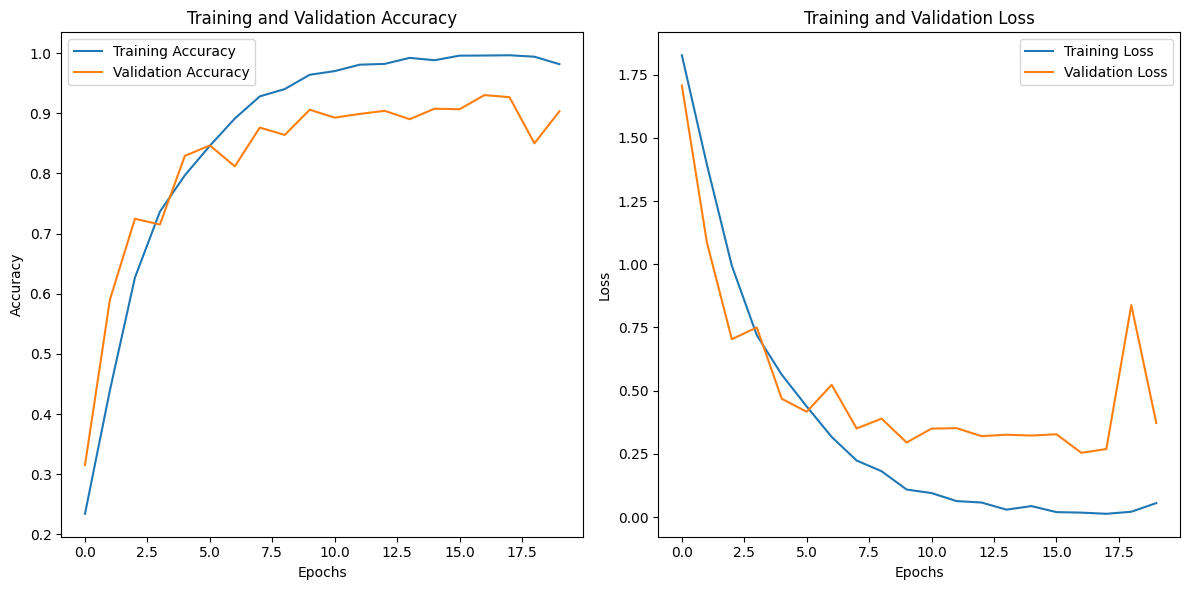

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()